# **KAU Deep Learning (Spring 2025)**



## Deep Feedforward Neural Networks example

In [ ]:
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


**Airplane Binary Classification Dataset**

This dataset is created from Cifar10(https://www.cs.toronto.edu/~kriz/cifar.html) and is used for image classification to determine whether an image is an airplane or not. It consists of a total of 10,000 train data and 2,000 test data, with airplane images labeled as 1 and no airplane images labeled as 0, evenly distributed in half of the dataset.

In [ ]:
import os
import zipfile
local_zip = "/content/drive/MyDrive/Colab Notebooks/2025_1 딥러닝/Airplane_binary_classification.zip"

zip_ref = zipfile.ZipFile(local_zip, 'r')
zip_ref.extractall('/dataset')
zip_ref.close()

In [ ]:
import pandas as pd
!ls -al /dataset
train_csv = pd.read_csv('/dataset/train_annotation.csv')
train_csv

total 356
drwxr-xr-x 4 root root   4096 May 14 07:22 .
drwxr-xr-x 1 root root   4096 May 14 07:22 ..
-rw-r--r-- 1 root root   1803 May 14 07:22 make_annotation.py
drwxr-xr-x 4 root root   4096 May 14 07:22 test
-rw-r--r-- 1 root root  55016 May 14 07:22 test_annotation.csv
drwxr-xr-x 4 root root   4096 May 14 07:22 train
-rw-r--r-- 1 root root 285016 May 14 07:22 train_annotation.csv


,filename,label
0,train/airplane/0001.png,1
1,train/airplane/0002.png,1
2,train/airplane/0003.png,1
3,train/airplane/0004.png,1
4,train/airplane/0005.png,1
...,...,...
9995,train/no_airplane/4996.png,0
9996,train/no_airplane/4997.png,0
9997,train/no_airplane/4998.png,0
9998,train/no_airplane/4999.png,0


First, implement a custom dataset to utilize the data.

In [ ]:
import torch
import pandas as pd
import os
from torchvision import transforms
import cv2

class AirplaneDataset(torch.utils.data.Dataset): ## make custom dataset
  def __init__(self, annotation_path, root_dir = '/dataset'): # root_dir : The parent directory path of the train and test directories.
        'Initialization'
        self.data_annotation = pd.read_csv(os.path.join(annotation_path))
        self.data_path = self.data_annotation['filename']
        self.labels = self.data_annotation['label']
        self.root_dir = root_dir
        self.to_tensor = transforms.ToTensor()

  def __len__(self):
        'Denotes the total number of samples'
        return len(self.data_path)

  def __getitem__(self, index):
        'Generates one sample of data'
        # Select sample
        file_path = os.path.join(self.root_dir, self.data_path[index])
        #input_image = Image.open(file_path)
        input_image = cv2.imread(file_path)
        input_image = cv2.cvtColor(input_image,cv2.COLOR_BGR2RGB)
        X = self.to_tensor(input_image)

        # Load data and get label
        y = torch.tensor(self.labels[index]).float()

        return X, y

Check the information about the dataset.

In [ ]:
import matplotlib.pyplot as plt
import random

## make by using custom dataset class
trainset = AirplaneDataset(annotation_path = '/dataset/train_annotation.csv')
testset = AirplaneDataset(annotation_path = '/dataset/test_annotation.csv')

# 데이터셋 길이 확인
print(f"Dataset length: {len(trainset)}")

# 첫 번째 샘플 확인
sample_X, sample_y = trainset[0]

# 샘플 데이터 형태 및 타입 확인
print(f"Sample X shape: {sample_X.shape}") # 토치의 텐서는 3,32,32 -->opencv에서 읽으려면 32,32,3으로 변경
print(f"Sample X type: {type(sample_X)}")
print(f"Sample X dtype: {sample_X.dtype}")

print(f"Sample y shape: {sample_y.shape}")
print(f"Sample y type: {type(sample_y)}")
print(f"Sample y dtype: {sample_y.dtype}")

# 데이터 속성 확인
print(f"Data paths: {trainset.data_path[:5]}") #처음 5개의 파일경로 출력
print(f"Labels: {trainset.labels[:5]}") # 처음 5개의 레이블 출력
print(f"Root directory: {trainset.root_dir}")


print("0th image data shape: ", trainset[0][0].shape) ## 0th image data
print("0th label : ", trainset[0][1]) ## label

Dataset length: 10000
Sample X shape: torch.Size([3, 32, 32])
Sample X type: <class 'torch.Tensor'>
Sample X dtype: torch.float32
Sample y shape: torch.Size([])
Sample y type: <class 'torch.Tensor'>
Sample y dtype: torch.float32
Data paths: 0    train/airplane/0001.png
1    train/airplane/0002.png
2    train/airplane/0003.png
3    train/airplane/0004.png
4    train/airplane/0005.png
Name: filename, dtype: object
Labels: 0    1
1    1
2    1
3    1
4    1
Name: label, dtype: int64
Root directory: /dataset
0th image data shape:  torch.Size([3, 32, 32])
0th label :  tensor(1.)


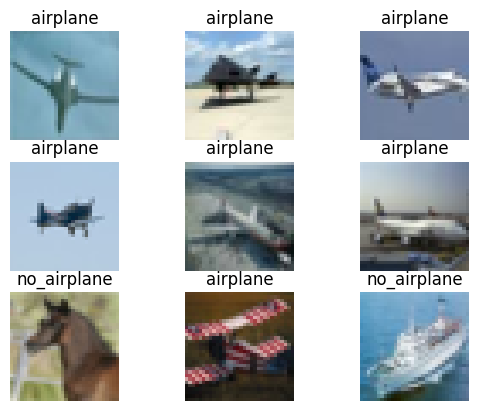

In [ ]:
## visualize
class_names=['no_airplane','airplane']
for i in range(9):
  random_index = random.randint(0,10000)
  image, label = trainset[random_index]
  ax = plt.subplot(3, 3, i + 1)
  plt.imshow(image.permute(1,2,0).numpy()) # torch의 3,32,32 형식의 데이터를 읽기 위해 32,32,3 형식으로 변경
  plt.title(class_names[int(label)])
  plt.axis("off")

In [ ]:
import torch
import torch.nn as nn

# 신경망 모델 정의
class SimpleMLP(nn.Module): # nn,Module을 상속해온다
    def __init__(self):
        super(SimpleMLP, self).__init__()
        self.flatten = nn.Flatten()  # Flatten layer (used to flatten the image into a 1D vector)
        self.fc1 = nn.Linear(3*32*32, 64)  # Input layer (connects flattened 3*32*32 pixel image to 64 neurons)
        self.fc2 = nn.Linear(64, 1)  # Output layer (1 neuron for binary classification) 0:비행기 아님 / 1:비행기

    def forward(self, x):
        x = self.flatten(x)  # Flatten the input image into a 1D vector (3x32x32)
        x = torch.relu(self.fc1(x))  # First fully connected layer with ReLU activation function
        x = self.fc2(x)  # Second fully connected layer
        x = torch.sigmoid(x) # Apply sigmoid activation function to obtain probability values for binary classification 마지막에 0또는 1이 되야하므로 sigmoid 사용
        return x

In [ ]:
## parameters
epoch = 10
batchsize = 8
lr = 0.01 # learning rate
weight_decay = 1e-3 # 매번 학습을 할 때 가중치를 줄여야 성능이 좋아짐

## dataloader
train_loader = torch.utils.data.DataLoader(trainset,
                                          batch_size=batchsize,
                                          shuffle=True)

test_loader = torch.utils.data.DataLoader(testset,
                                          batch_size=1,
                                          shuffle=True)

## make model and using GPU
device = 'cuda' if torch.cuda.is_available() else 'cpu'
model = SimpleMLP().to(device)
print(model)

## optimizer setting
optimizer = torch.optim.SGD(model.parameters(),
                            lr=lr,
                            weight_decay = weight_decay) # Stochastic Gradient Decent

## loss function
criterion = torch.nn.BCELoss() # Binary Cross Entropy

SimpleMLP(
  (flatten): Flatten(start_dim=1, end_dim=-1)
  (fc1): Linear(in_features=3072, out_features=64, bias=True)
  (fc2): Linear(in_features=64, out_features=1, bias=True)
)


Define train and test functions and train the model.

In [ ]:
def train(model, optimizer, train_loader, epoch):
  train_loss = []
  train_accuracy = []
  model.train()

  for i, (X,y) in enumerate(train_loader):
      X,y = X.to(device), y.to(device).view(-1,1) # y의 차원을 1->2로 변경 (8,)->(8,1)
      #print('shape of X:', X.shape) # X : [8,3,32,32]
      #print('shape of y:', y.shape) # y: [8,1]--y의 차원이 2로 변경된것 확인
      #break

      optimizer.zero_grad()
      predict = model(X)
      loss = criterion(predict, y)
      loss.backward()
      optimizer.step()

      accuracy = torch.count_nonzero((predict>=0.5) == y)/X.shape[0]
      train_accuracy.append(accuracy)
      train_loss.append(loss)

  avg_loss = sum(train_loss) /len(train_loss)
  avg_accuracy = sum(train_accuracy) / len(train_accuracy)

  print(f'epoch {epoch}) train loss : {avg_loss:.4f} / train_accuracy : {avg_accuracy:.4f}')

def test(model, optimizer, test_loader, epoch):
  test_loss = []
  test_accuracy = []
  model.eval()

  for i, (X,y) in enumerate(test_loader):
      with torch.no_grad(): ## Since backward computation is not necessary during test time, turning off grad reduces memory and computational overhead.
        X,y = X.to(device), y.to(device).view(-1,1)
        predict = model(X)
        loss = criterion(predict, y)
        accuracy = torch.count_nonzero((predict>=0.5) == y)
        test_accuracy.append(accuracy)
        test_loss.append(loss)

  avg_loss = sum(test_loss) /len(test_loss)
  avg_accuracy = sum(test_accuracy) / len(test_accuracy)

  print(f'epoch {epoch}) test loss : {avg_loss:.4f} / test_accuracy : {avg_accuracy:.4f}')

for i in range(epoch):
    train(model, optimizer, train_loader, i)
    test(model, optimizer, test_loader, i)



epoch 0) train loss : 0.5751 / train_accuracy : 0.7013
epoch 0) test loss : 0.5281 / test_accuracy : 0.7525
epoch 1) train loss : 0.5297 / train_accuracy : 0.7394
epoch 1) test loss : 0.5454 / test_accuracy : 0.7070
epoch 2) train loss : 0.5154 / train_accuracy : 0.7533
epoch 2) test loss : 0.4921 / test_accuracy : 0.7695
epoch 3) train loss : 0.5044 / train_accuracy : 0.7567
epoch 3) test loss : 0.4962 / test_accuracy : 0.7590
epoch 4) train loss : 0.4918 / train_accuracy : 0.7667
epoch 4) test loss : 0.5505 / test_accuracy : 0.7085
epoch 5) train loss : 0.4843 / train_accuracy : 0.7729
epoch 5) test loss : 0.5365 / test_accuracy : 0.7305
epoch 6) train loss : 0.4768 / train_accuracy : 0.7759
epoch 6) test loss : 0.5182 / test_accuracy : 0.7475
epoch 7) train loss : 0.4707 / train_accuracy : 0.7776
epoch 7) test loss : 0.4672 / test_accuracy : 0.7820
epoch 8) train loss : 0.4617 / train_accuracy : 0.7840
epoch 8) test loss : 0.4463 / test_accuracy : 0.7975
epoch 9) train loss : 0.4571

## Lab Activity
 Build your own classification system for MNIST dataset

0th image data shape:  torch.Size([1, 28, 28])
0th label :  5


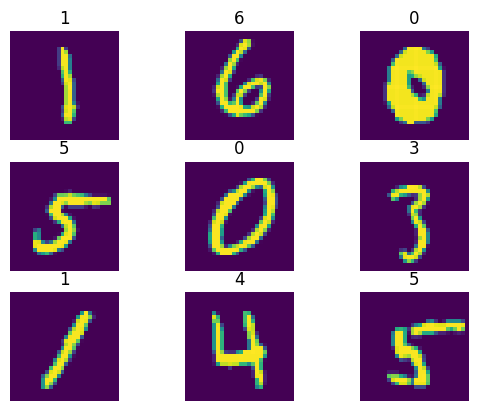

In [ ]:
import matplotlib.pyplot as plt
import random
import torchvision
from torchvision.datasets import MNIST ## load MNIST dataset from torchvision
import torchvision.transforms as transforms

trainset = MNIST(root='data/', download=True,
                 transform=transforms.Compose([transforms.ToTensor()]))
testset = MNIST(root='data/', train=False,
                 transform=transforms.Compose([transforms.ToTensor()]))

print("0th image data shape: ", trainset[0][0].shape) ## 0th image data
print("0th label : ", trainset[0][1]) ## label

# visualize
for i in range(9):
   random_index = random.randint(1,10000)
   image, label = trainset[random_index]
   ax = plt.subplot(3, 3, i + 1)
   plt.imshow(image.permute(1,2,0).numpy())
   plt.title(label)
   plt.axis("off")

In [ ]:
# MNIST 신경망 구축
class MNIST_mlp(nn.Module):
    def __init__(self):
        super(MNIST_mlp, self).__init__()
        self.fc1 = nn.Linear(28 * 28, 128)
        self.fc2 = nn.Linear(128, 64)
        self.fc3 = nn.Linear(64, 10)

    def forward(self, x):
        x = x.view(-1, 28 * 28)
        x = torch.relu(self.fc1(x))
        x = torch.relu(self.fc2(x))
        x = self.fc3(x)
        return x


In [ ]:
## parameters
epoch = 50
batchsize = 8
lr = 0.01 # learning rate
weight_decay = 1e-3 # 매번 학습을 할 때 가중치를 줄여야 성능이 좋아짐

## dataloader
train_loader = torch.utils.data.DataLoader(trainset,
                                          batch_size=batchsize,
                                          shuffle=True)

test_loader = torch.utils.data.DataLoader(testset,
                                          batch_size=1,
                                          shuffle=True)

## make model and using GPU
device = 'cuda' if torch.cuda.is_available() else 'cpu'
model = MNIST_mlp().to(device)
print(model)

## optimizer setting
optimizer = torch.optim.SGD(model.parameters(),
                            lr=lr,
                            weight_decay = weight_decay) # Stochastic Gradient Decent

## loss function
loss_function = torch.nn.CrossEntropyLoss() # MNIST에 적절한 Cross Entropy Loss로 변경

MNIST_mlp(
  (fc1): Linear(in_features=784, out_features=128, bias=True)
  (fc2): Linear(in_features=128, out_features=64, bias=True)
  (fc3): Linear(in_features=64, out_features=10, bias=True)
)


In [ ]:
# MNIST 훈련함수 정의
# 그래프를 나중에 그리기 위해 loss, accuracy를 따로 빼놈
train_loss = []
train_accuracy = []

def train(model, optimizer, train_loader, epoch):
  #train_loss = []
  #train_accuracy = []
  model.train()

  for i, (X,y) in enumerate(train_loader):
      X,y = X.to(device), y.to(device)
      #print('shape of X:', X.shape) # X : [8,3,32,32]
      #print('shape of y:', y.shape) # y: [8,1]--y의 차원이 2로 변경된것 확인
      #break

      optimizer.zero_grad()
      predict = model(X)
      loss = loss_function(predict, y)
      loss.backward()
      optimizer.step()

      accuracy = torch.count_nonzero(torch.argmax(predict, dim=1) == y)/X.shape[0]
      train_accuracy.append(accuracy)
      train_loss.append(loss)

  avg_loss = sum(train_loss) /len(train_loss)
  avg_accuracy = sum(train_accuracy) / len(train_accuracy)

  print(f'epoch {epoch}) train loss : {avg_loss:.4f} / train_accuracy : {avg_accuracy:.4f}')



In [ ]:
# MNIST 테스트 함수 정의
# 그래프를 나중에 그리기 위해 loss, accuracy를 따로 빼놈
test_loss = []
test_accuracy = []

def test(model, optimizer, test_loader, epoch):
  #test_loss = []
  #test_accuracy = []
  model.eval()

  for i, (X,y) in enumerate(test_loader):
      with torch.no_grad(): ## Since backward computation is not necessary during test time, turning off grad reduces memory and computational overhead.
        X,y = X.to(device), y.to(device)
        predict = model(X)
        loss = loss_function(predict, y)
        accuracy = torch.count_nonzero(torch.argmax(predict, dim=1) == y)/X.shape[0]
        test_accuracy.append(accuracy)
        test_loss.append(loss)

  avg_loss = sum(test_loss) /len(test_loss)
  avg_accuracy = sum(test_accuracy) / len(test_accuracy)

  print(f'epoch {epoch}) test loss : {avg_loss:.4f} / test_accuracy : {avg_accuracy:.4f}')


In [ ]:
# 모델 훈련 결과
for i in range(epoch):
    train(model, optimizer, train_loader, i)


epoch 0) train loss : 0.4573 / train_accuracy : 0.8701
epoch 1) train loss : 0.3497 / train_accuracy : 0.9004
epoch 2) train loss : 0.2913 / train_accuracy : 0.9169
epoch 3) train loss : 0.2529 / train_accuracy : 0.9278
epoch 4) train loss : 0.2254 / train_accuracy : 0.9357
epoch 5) train loss : 0.2043 / train_accuracy : 0.9418
epoch 6) train loss : 0.1878 / train_accuracy : 0.9466
epoch 7) train loss : 0.1743 / train_accuracy : 0.9505
epoch 8) train loss : 0.1630 / train_accuracy : 0.9537
epoch 9) train loss : 0.1535 / train_accuracy : 0.9565
epoch 10) train loss : 0.1454 / train_accuracy : 0.9589
epoch 11) train loss : 0.1383 / train_accuracy : 0.9610
epoch 12) train loss : 0.1321 / train_accuracy : 0.9628
epoch 13) train loss : 0.1266 / train_accuracy : 0.9644
epoch 14) train loss : 0.1217 / train_accuracy : 0.9658
epoch 15) train loss : 0.1173 / train_accuracy : 0.9672
epoch 16) train loss : 0.1133 / train_accuracy : 0.9683
epoch 17) train loss : 0.1097 / train_accuracy : 0.9694
ep

In [ ]:
# 모델 테스트 결과
for i in range(epoch):
    test(model, optimizer, test_loader, i)


epoch 0) test loss : 0.0665 / test_accuracy : 0.9805
epoch 1) test loss : 0.0665 / test_accuracy : 0.9805
epoch 2) test loss : 0.0665 / test_accuracy : 0.9805
epoch 3) test loss : 0.0665 / test_accuracy : 0.9805
epoch 4) test loss : 0.0665 / test_accuracy : 0.9805
epoch 5) test loss : 0.0665 / test_accuracy : 0.9805
epoch 6) test loss : 0.0665 / test_accuracy : 0.9805
epoch 7) test loss : 0.0665 / test_accuracy : 0.9805
epoch 8) test loss : 0.0665 / test_accuracy : 0.9805
epoch 9) test loss : 0.0665 / test_accuracy : 0.9805
epoch 10) test loss : 0.0665 / test_accuracy : 0.9805
epoch 11) test loss : 0.0665 / test_accuracy : 0.9805
epoch 12) test loss : 0.0665 / test_accuracy : 0.9805
epoch 13) test loss : 0.0665 / test_accuracy : 0.9805
epoch 14) test loss : 0.0665 / test_accuracy : 0.9805
epoch 15) test loss : 0.0665 / test_accuracy : 0.9805
epoch 16) test loss : 0.0665 / test_accuracy : 0.9805
epoch 17) test loss : 0.0665 / test_accuracy : 0.9805
epoch 18) test loss : 0.0665 / test_ac

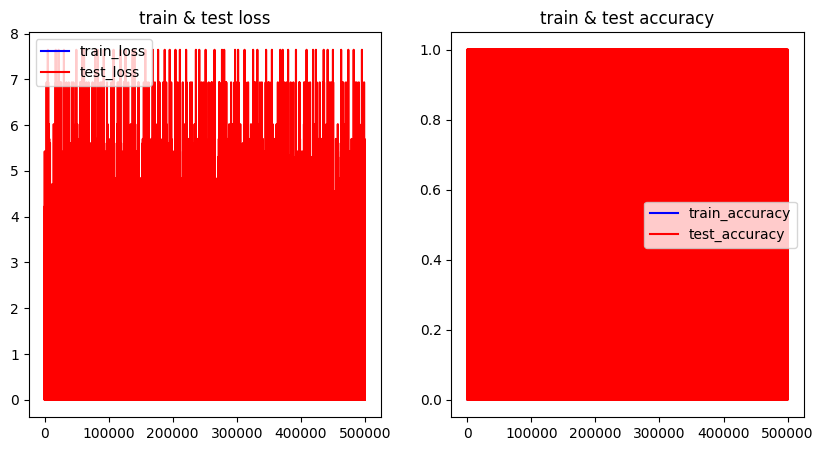

In [ ]:
# 훈련결과와 테스트 결과 loss, accuracy 그래프로 표현
import numpy as np
import matplotlib.pyplot as plt
train_loss = np.array(train_loss)
train_accuracy = np.array(train_accuracy)
test_loss = np.array(test_loss)
test_accuracy = np.array(test_accuracy)

plt.figure(figsize=(10,5))
plt.subplot(1,2,1)
plt.plot(train_loss, label='train_loss',color='blue')
plt.plot(test_loss, label='test_loss',color='red')
plt.legend()
plt.title('train & test loss')

plt.subplot(1,2,2)
plt.plot(train_accuracy, label='train_accuracy',color='blue')
plt.plot(test_accuracy, label='test_accuracy',color='red')
plt.legend()
plt.title('train & test accuracy')

plt.show()
